# Imports

In [1]:
import torch
import torchvision
from glob import glob
import matplotlib.pyplot as plt
import zipfile

In [2]:
# download and import the 'align' module
!wget https://raw.githubusercontent.com/martin-marek/hdr-plus-pytorch/main/align.py
import align

--2021-04-19 18:38:25--  https://raw.githubusercontent.com/martin-marek/hdr-plus-pytorch/main/align.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10865 (11K) [text/plain]
Saving to: ‘align.py’

align.py            100%[===================>]  10.61K  --.-KB/s    in 0s      

2021-04-19 18:38:25 (25.8 MB/s) - ‘align.py’ saved [10865/10865]



In [3]:
# set PyTorch device (currently, only 'cuda' is supported)
device = torch.device('cuda')

# Load images

In [4]:
# download and unzip a burst of jpeg images
# the images are all less than 3 megapixels, higher resolutions are not supported
!wget https://storage.googleapis.com/hdr-plus-samples/Monika-RX100-51200.zip
with zipfile.ZipFile('Monika-RX100-51200.zip', 'r') as z:
    z.extractall()

--2021-04-19 18:38:27--  https://storage.googleapis.com/hdr-plus-samples/Monika-RX100-51200.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161165880 (154M) [application/zip]
Saving to: ‘Monika-RX100-51200.zip’

Monika-RX100-51200. 100%[===================>] 153.70M   177MB/s    in 0.9s    

2021-04-19 18:38:28 (177 MB/s) - ‘Monika-RX100-51200.zip’ saved [161165880/161165880]



In [5]:
# load the images
images = []
image_dir = 'Monika-RX100-51200'
for path in sorted(glob(f'{image_dir}/*.jpg')):
    image = torchvision.io.read_image(path)
    image = image.to(device)
    image = image.to(torch.float16) / 255
    images.append(image)
images = torch.stack(images)
print(f'Burst shape: {list(images.shape)}')
N, C, H, W = images.shape

Burst shape: [35, 3, 2000, 1333]


# Display images

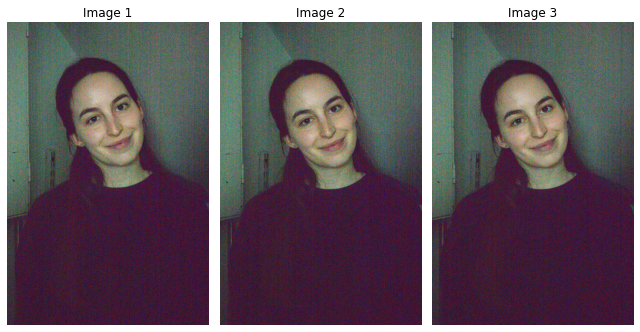

In [6]:
n = 3 # only plot first n images
fig, axs = plt.subplots(1, n, figsize=(3*n, 8))
for i in range(n):
    axs[i].imshow(images[i].float().to('cpu').permute(1, 2, 0))
    axs[i].set_title(f'Image {i+1}')
    axs[i].set_aspect(1)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Split images

Split images into a 'reference' image and 'comparison' images which are to be aligned with the 'reference' image.

In [7]:
ref_idx = 0
ref_image = images[ref_idx]
comp_images = images[torch.arange(len(images)) != ref_idx]

# Align images

In [8]:
aligned_images = align.align_images(ref_image, comp_images)

# Merge images

In [9]:
# merge the aligned images
merged_image = (ref_image + aligned_images.sum(0)) / (1 + len(aligned_images))
merged_image = torch.clip(merged_image, 0, 1)

# save merged image
torchvision.io.write_jpeg((merged_image.cpu()*255).to(torch.uint8), f'merged_image.jpg')

# Plot reference vs. merged image

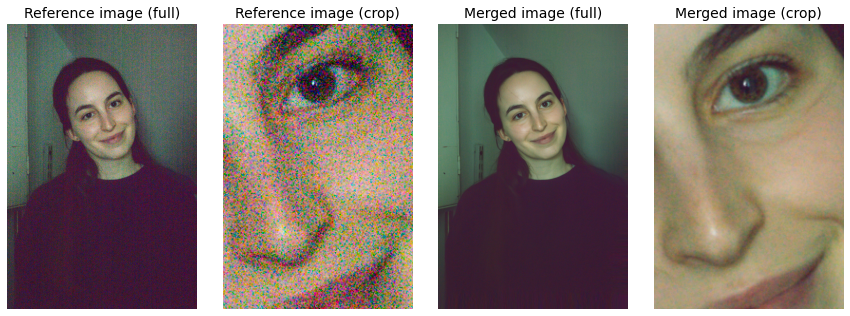

In [11]:
# crop
crop_y = [500, 800]
crop_x = [650, 850]

# reference image
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[12, 8])
axs[0].imshow(ref_image.to('cpu').float().permute(1, 2, 0))
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(ref_image[:, crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1]].to('cpu').float().permute(1, 2, 0))
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_image.to('cpu').float().permute(1, 2, 0))
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_image[:, crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1]].to('cpu').float().permute(1, 2, 0))
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
plt.show()